In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

text_width = 6.30107 # in  --> Confirmed with template explanation

fs_m1 = 8  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  # figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'sans-serif', 'sans-serif': ['Helvetica']})
matplotlib.rc('text', usetex=True)
#plt.style.use(['paper.mplstyle'])

In [3]:
n_targets = 8
times = [300]
hand_targets = np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/eval_rad_abg_av/hand_targets")
def get_dir(alpha_null, alpha_effort):
    return f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams/monkeys_0.01_{alpha_null}_{alpha_effort}/ramping_soc/seed_0_mixed"

def hands(dir, i, t):
    idces = [0,2]
    h = np.loadtxt(f'{dir}/hands_{i}_{t}')[:,idces]
    return h - h[0]

def torques(dir, i, t):
    h = np.loadtxt(f'{dir}/torques_{i}_{t}')
    return h

def prep_idx(lam, t_coeff= 1.0):
    dir = get_dir(lam, t_coeff)
    def get_prep_idx(us, t):
        if t == 0:
            return 0
        else : 
            cutoff = int(t/2 )
            u_prep, u_mov = us[:cutoff+1], us[cutoff+1:]
            return np.sum(u_prep**2)/np.sum(u_mov**2)
    def us(t,i):
        return np.loadtxt(f"{dir}/us_{i}_{t}")
    def get_all_idces(i):
        try : 
            ai = np.asarray([get_prep_idx(us(t, i),t) for t in times])
            return ai
        except:
            pass
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs if get_all_idces(i) is not None], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def input_amount(lam, t_coeff= 1.0):
    dir = get_dir(lam, t_coeff)
    def get_prep_idx(us, t):
        return np.sum(us**2)
    def us(t,i):
        return np.loadtxt(f"{dir}/us_{i}_{t}")
    def get_all_idces(i):
        try : 
            ai = np.asarray([get_prep_idx(us(t, i),t) for t in times])
            return ai
        except : 
            pass
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs if get_all_idces(i) is not None], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v


def max_vel(lam, t_coeff= 1.0):
    dir = get_dir(lam, t_coeff)
    def get_max_vel(hands):
        vel = np.sqrt(hands[:,1]**2+hands[:,3]**2)
        return np.max(vel)
    def hands(t,i):
        return np.loadtxt(f"{dir}/hands_{i}_{t}")
    def get_all_idces(i):
        try : 
            ai = np.asarray([get_max_vel(hands(t, i)) for t in times])
            return ai
        except : 
            pass
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs if get_all_idces(i) is not None], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_u(lam, t_coeff= 1.0):
    dir = get_dir(lam, t_coeff)
    def cost_u(t, i):
       return np.loadtxt(f'{dir}/u_cost_{i}_{t}')[-1]/lam
    def get_all_idces(i):
        try :
            ai = np.asarray([cost_u(t,i) for t in times])
            return ai
        except : 
            pass
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs if get_all_idces(i) is not None], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_tgt(lam, t_coeff= 1.0):
    dir = get_dir(lam, t_coeff)
    def cost_tgt(t, i):
       return np.loadtxt(f'{dir}/task_cost_{i}_{t}')[-1]
    def get_all_idces(i):
        try:
            ai = np.asarray([cost_tgt(t,i) for t in times])
            return ai
        except: 
            pass
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs if get_all_idces(i) is not None], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v


def mv_loss(lam, t_coeff= 1.0):
    dir = get_dir(lam, t_coeff)
    def cost_torques(t, i):
       return np.loadtxt(f'{dir}/loss_{i}_{t}').sum()
    def get_all_idces(i):
        try : 
            ai = np.asarray([cost_torques(t,i) for t in times])
            return ai
        except : 
            pass
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs if get_all_idces(i) is not None], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def successful_reach(lam, t_coeff=1.0):
    dir = get_dir(lam, t_coeff)
    def get_mov_time(mov, tgt):
        end_pos = mov[-100:,:2]
        end_diff = np.linalg.norm(end_pos - tgt, axis=1)
        failures = np.sum(np.where(end_diff> 0.01, 1., 0.))
        return failures
    def get_all_idces(i):
        tgt = hand_targets[i]
        try : 
            ai = np.asarray([get_mov_time(hands(dir, i, t), tgt) for t in times if get_mov_time(hands(dir, i, t), tgt) is not None])
            return ai
        except : 
            pass
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs if get_all_idces(i) is not None], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def successful_hold(lam, t_coeff=1.0):
    dir = get_dir(lam, t_coeff)
    def get_torques_prep(i, t):
        max_t = np.max(np.linalg.norm(torques(dir, i, t), axis=1))
        torques_prep = torques(dir, i, t)[:int(t/2),:]
        diff = np.linalg.norm(torques_prep, axis=1)
        failures = np.sum(np.where(diff> 0.02*max_t, 1., 0.))
        return failures
    def get_all_idces(i):
        tgt = hand_targets[i]
        try : 
            ai = np.asarray([get_torques_prep(i,t) for t in times])
            return ai
        except : 
            pass
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs if get_all_idces(i) is not None], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

In [4]:
t_coeff = "1.0" 
lam = "0.00001"
m_loss, _ =  mv_loss(lam, t_coeff)
sr, _ = successful_reach(lam, t_coeff)
sh, _ = successful_hold(lam, t_coeff)
print(sr,sh)



ValueError: need at least one array to concatenate

## Add a heatmap of what happens for different parameters

In [ ]:
t_coeffs = ["1.0", '2.0', "5.0", "6.0", "7.0", "8.0", "9.0"]
# "10.0"]
lambdas = ["0.00000009","0.0000001", "0.0000002", "0.0000003", "0.0000004", "0.0000005", "0.0000006", "0.0000007", "0.0000008", "0.0000009", "0.000001"]
srs = []
shs = []
pis = []
losses = []
tot_us = []
max_vels = []
for tc in t_coeffs :
    srts, shts, pits, losses_ts, tot_uts, max_velts = [], [], [], [], [], []
    for lam in lambdas : 
        print(tc,lam)
        sr, _ = successful_reach(lam, tc)
        sh, _ = successful_hold(lam, tc)
        print(sh)
        sr = np.where(sr > 0, 0, 1)
        sh = np.where(sh > 2, 0, 1)
        pi, _ = prep_idx(lam, tc)
        ml, _ = mv_loss(lam, tc)
        mv, _ = max_vel(lam, tc)
        tot_u, _ = input_amount(lam, tc)
        srts += [sr]
        shts += [sh]
        pits += [pi]
        losses_ts += [ml]
        tot_uts += [tot_u]
        max_velts += [mv]
    srs += [srts]
    shs += [shts]
    pis += [pits]
    max_vels += [max_velts]
    losses += [losses_ts]
    tot_us += [tot_uts]
srs = np.asarray(srs)[:,:,-1]
shs = np.asarray(shs)[:,:,-1]
pis = np.asarray(pis)[:,:,-1]
losses = np.asarray(losses)[:,:,-1]
tot_us = np.asarray(tot_us)[:,:,-1]
max_vels = np.asarray(max_vels)[:,:,-1]

1.0 0.00000009


ValueError: need at least one array to concatenate

TypeError: Invalid shape (0,) for image data

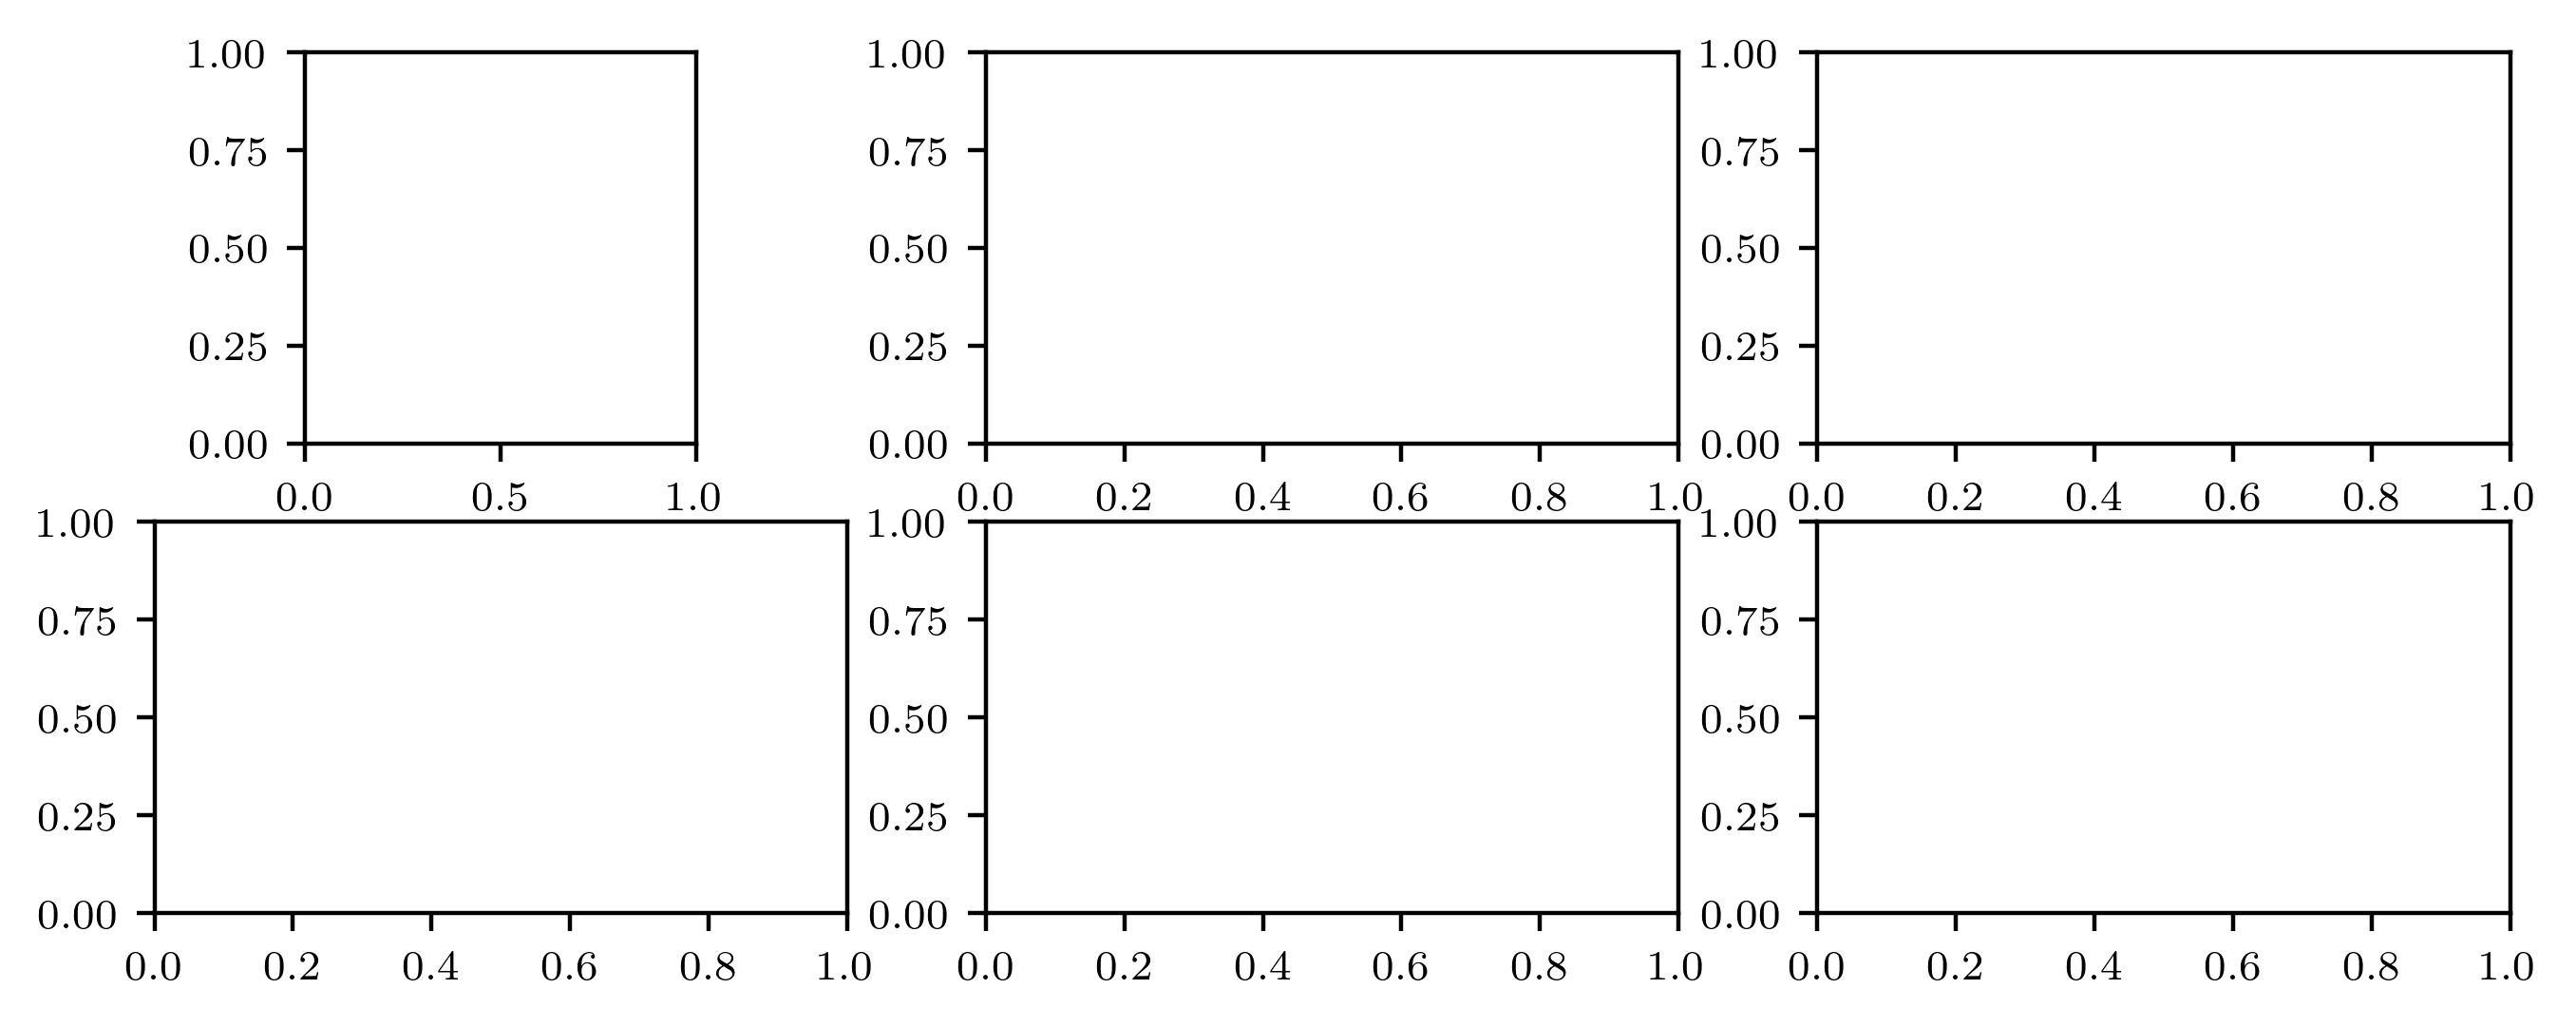

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3,  figsize=(8, 3), dpi = 400)
import matplotlib as mpl
#mpl.rcParams['ticks.size'] = fs_m1
## Successful reach?
#axes[0,0].imshow(srs, cmap = "coolwarm")
p = axes[0,0].imshow(srs, cmap = "gray")
axes[0,0].set_title("Reach success", fontsize = fs)
fig.colorbar(p, ax = axes[0,0])
axes[0,0].set_xticks(range(len(lambdas)), [], fontsize = fs_m1)
axes[0,0].set_yticks(range(len(t_coeffs)), [float(t) for t in t_coeffs], fontsize = fs_m1)
## Successful hold?
p = axes[1,0].imshow(shs, cmap = "gray")
fig.colorbar(p, ax = axes[1,0])
axes[1,0].set_title("Holding success", fontsize = fs)
axes[1,0].set_xticks(range(len(lambdas)), [float(l)*1E7 for l in lambdas], fontsize = fs_m1)
axes[1,0].set_yticks(range(len(t_coeffs)), [float(t) for t in t_coeffs], fontsize = fs_m1)
## Prep index?
p = axes[0,1].imshow(pis, cmap = "coolwarm")
fig.colorbar(p, ax = axes[0,1])
axes[0,1].set_title("Prep index", fontsize = fs)
axes[0,1].set_xticks(range(len(lambdas)),  [])
axes[0,1].set_yticks(range(len(t_coeffs)), [], fontsize = fs_m1)
## Loss
p = axes[1,1].imshow(losses, cmap = "coolwarm")
fig.colorbar(p, ax = axes[1,1])
axes[1,1].set_title("Total cost", fontsize = fs)
axes[1,1].set_xticks(range(len(lambdas)), [float(l)*1E7 for l in lambdas], fontsize = fs_m1)
axes[1,1].set_yticks(range(len(t_coeffs)),  [], fontsize = fs_m1)
## Input amount
p = axes[0,2].imshow(tot_us, cmap = "coolwarm")
fig.colorbar(p, ax = axes[0,2])
axes[0,2].set_title("Input energy", fontsize = fs)
axes[0,2].set_xticks(range(len(lambdas)),  [])
axes[0,2].set_yticks(range(len(t_coeffs)),  [])
## Max velocity
p = axes[1,2].imshow(max_vels, cmap = "coolwarm")
fig.colorbar(p, ax = axes[1,2])
axes[1,2].set_title("Max velocity", fontsize = fs)
axes[1,2].set_xticks(range(len(lambdas)), [float(l)*1E7 for l in lambdas], fontsize = fs_m1)
axes[1,2].set_yticks(range(len(t_coeffs)),  [])

#labels
fig.text(0.5, 0.01, '$\\alpha_{\\textrm{effort}} (\\times 10^{7})$', size = 8)
fig.text(0.07, 0.5, '$\\alpha_{\\textrm{null}}$', size = 8, rotation="vertical")
fig.savefig("hyperparams.pdf", format = "pdf", bbox_inches='tight')

In [ ]:
#plot cost target as a function of cost u and of cost null

def cost_torques(lam, t_coeff= 1.0):
    dir = get_dir(lam, t_coeff)
    def cost_torques(t, i):
       c = np.loadtxt(f'{dir}/task_cost_{i}_{t}')
       return c
    def get_all_idces(i):
        try:
            ai = np.asarray([cost_torques(t,i)[0] for t in times])
            return ai
        except : 
            pass
    movs = range(n_targets)
    idces = np.asarray([get_all_idces(i) for i in movs if get_all_idces(i) is not None])
    m, v = np.mean(idces), np.std(idces)/np.sqrt(n_targets)
    return m, v


jus, jnulls, jtgts = [], [], []
alpha_nulls, alpha_effs = [], []
for tc in t_coeffs :
    for lam in lambdas :
        print(tc, lam) 
        ju, _ = input_amount(lam, tc)
        jn, _ = cost_torques(lam, tc)
        jn = jn/float(tc)
        jtgt, _ = cost_tgt(lam, tc)
        jus += [ju]
        jnulls += [jn]
        jtgts += [jtgt]
        alpha_nulls += [tc]
        alpha_effs += [lam]
jus = np.asarray(jus)
jtgts = np.asarray(jtgts)
jnulls = np.asarray(jnulls)
alpha_effs = np.asarray(alpha_effs)
alpha_nulls = np.asarray(alpha_nulls)


In [ ]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

# plt.style.use(['paper.mplstyle'])
text_width = 6.30107 # in  --> Confirmed with template explanation

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  # figure titles



# axes.spines.right   : False
# axes.spines.top     : False
mpl.rcParams['axes.spines.right'] =  False
mpl.rcParams['axes.spines.top'] =  False
# matplotlib.rc('axes.spines.top', set_visible=False)
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})



In [ ]:
fig, ax = plt.subplots(figsize=(3,1), dpi=400)
palette1 = sns.color_palette("magma", len(t_coeffs))
ts = {t_coeffs[i]: i for i in range(len(t_coeffs))} 
palette0 = sns.color_palette("magma", as_cmap = True)
effs = {lambdas[i]: i for i in range(len(lambdas))} 
ze = np.asarray([float(alpha) for alpha in alpha_effs])
scaled_z = (ze - ze.min()) / ze.ptp()
#scaled_z = ze
colors = plt.cm.hot(scaled_z)
p = ax.scatter(1E-7*jus, jtgts/100, marker='o', s=0.8, c=colors)
ax.set_xlabel("$\\mathcal{J}_{\\textrm{effort}}/\\alpha_{\\textrm{effort}}  (\\times 10^{-7})$")
ax.set_ylabel("$\\mathcal{J}_{\\textrm{tgt}}/\\alpha_{\\textrm{tgt}}$")
ax.set_xticks([0,0.3,0.6, 0.9, 1.2],[0,0.3,0.6, 0.9, 1.2])
ax.set_yticks([0,1,2],[0,1,2])
fig.colorbar(mpl.cm.ScalarMappable(cmap=mpl.cm.hot))
fig.savefig("j_eff_tgt.pdf", format = "pdf", bbox_inches='tight')
# ze = np.asarray([float(alpha) for alpha in alpha_nulls])
# scaled_z = (ze - ze.min()) / ze.ptp()
# p = axes[1].scatter(jnulls, jtgts/100, marker='o',  c=colors)
# fig.colorbar(p, ax = axes[1])

# scaled_z = (z - z.min()) / z.ptp()
# colors = plt.cm.coolwarm(scaled_z)

# plt.scatter(x, y, marker='+', edgecolors=colors, s=150, linewidths=4)
# plt.show()

In [ ]:
t_coeffs = ["0.250", "0.500", "1.000", "2.000", "3.000", "4.000", "5.000", "6.000", "7.000"]
lambdas = ["0.00000005", "0.00000006",  "0.00000007", "0.00000010","0.00000050","0.00000200", "0.00000300", "0.00000400", "0.00000500", "0.00000600", "0.00000700", "0.00000800", "0.00000900", "0.00001000", "0.00002000", "0.00003000", "0.00004000", "0.00005000", "0.00006000", "0.00007000", "0.00008000", "0.00009000", "0.00010000", "0.00020000", "0.00030000", "0.00040000", "0.00050000", "0.00060000", "0.00070000", "0.00080000", "0.00090000", "0.00100000", "0.00200000", "0.00300000", "0.00400000", "0.00500000", "0.00600000", "0.00700000", "0.00800000",  "0.00900000"]
# "0.0000050", "0.0000060", "0.0000070", "0.0000080", "0.0000090", "0.0000100", "0.0000200", "0.0000300", "0.0000400", "0.0000500", "0.0000600", "0.0000700","0.0000800", "0.0000900"]
print(lambdas)
srs = []
shs = []
pis = []
losses = []
tot_us = []
max_vels = []
''' [| t_prep
        ; prep_idx
        ; loss
        ; input_cost_prep
        ; input_cost_mov
        ; input_cost_tot
        ; torque_err
        ; target_err
        ; ratio_u_cost
        ; max_vel
        ; mean_d_to_tgt
        ; mean_vel_beg |]'''
def get_summary(lam, tc, reach, nprep):
    sums = []
    for n in range(4):
        try : 
            fname = f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/summary_{lam}_{tc}_{n}_{nprep}"
            sums.append(np.loadtxt(fname)[None,:])
        except :
            assert True
    return np.mean(np.concatenate(sums, axis=0), axis=0)
hand_targets = np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/hand_targets")
def get_sr(lam, tc, reach, nprep):
    sums = []
    for n in range(4):
        try: 
            fname = f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/hands_{lam}_{tc}_{n}_{nprep}"
            hands = np.concatenate([np.loadtxt(fname)[:,0][:,None], np.loadtxt(fname)[:,2][:,None]], axis=1)
            #[None,[0,2]]
            diff_tgt = hands - hands[0,:] - hand_targets[0]
            mean_d = np.mean(np.linalg.norm(diff_tgt[-100:], axis=1))
            sums.append(mean_d)
        except: 
            assert True
    return np.mean(np.asarray(sums))
for tc in t_coeffs :
    srts, shts, pits, losses_ts, tot_uts, max_velts = [], [], [], [], [], []
    for lam in lambdas : 
        summary_300 = get_summary(lam, tc, 1, 150)
        sr = get_sr(lam, tc, 1, 150)
        sh = summary_300[-1]
        sr = 1 if sr < 0.005 else 0
        sh = 1 if sh < 0.02 else 0
        pi = summary_300[1]
        ml = summary_300[2]
        tot_u = summary_300[5]
        max_vel = summary_300[6]#summary_300[-4]
        assert (not np.isnan(max_vel))
        srts += [sr]
        shts += [sh]
        pits += [pi]
        losses_ts += [ml]
        tot_uts += [tot_u/float(lam)/1000/200]
        max_velts += [max_vel]
    srs += [srts]
    shs += [shts]
    pis += [pits]
    losses += [losses_ts]
    tot_us += [tot_uts]
    max_vels += [max_velts]
srs = np.asarray(srs)[:,:]
shs = np.asarray(shs)[:,:]
pis = np.asarray(pis)[:,:]
losses = np.asarray(losses)[:,:]
tot_us = np.asarray(tot_us)[:,:]
max_vels = np.asarray(max_vels)[:,:]

['0.00000005', '0.00000006', '0.00000007', '0.00000010', '0.00000050', '0.00000200', '0.00000300', '0.00000400', '0.00000500', '0.00000600', '0.00000700', '0.00000800', '0.00000900', '0.00001000', '0.00002000', '0.00003000', '0.00004000', '0.00005000', '0.00006000', '0.00007000', '0.00008000', '0.00009000', '0.00010000', '0.00020000', '0.00030000', '0.00040000', '0.00050000', '0.00060000', '0.00070000', '0.00080000', '0.00090000', '0.00100000', '0.00200000', '0.00300000', '0.00400000', '0.00500000', '0.00600000', '0.00700000', '0.00800000', '0.00900000']


/tmp/ipykernel_1526128/769288598.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[0,0].yaxis.get_ticklocs()])
/tmp/ipykernel_1526128/769288598.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].xaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,0].xaxis.get_ticklocs()])
/tmp/ipykernel_1526128/769288598.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,0].yaxis.get_ticklocs()])
/tmp/ipykernel_1526128/769288598.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[0,1].yaxis.get_ticklocs()])
/tmp/ipykernel_1526128/769288598.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,1].yaxis.ge

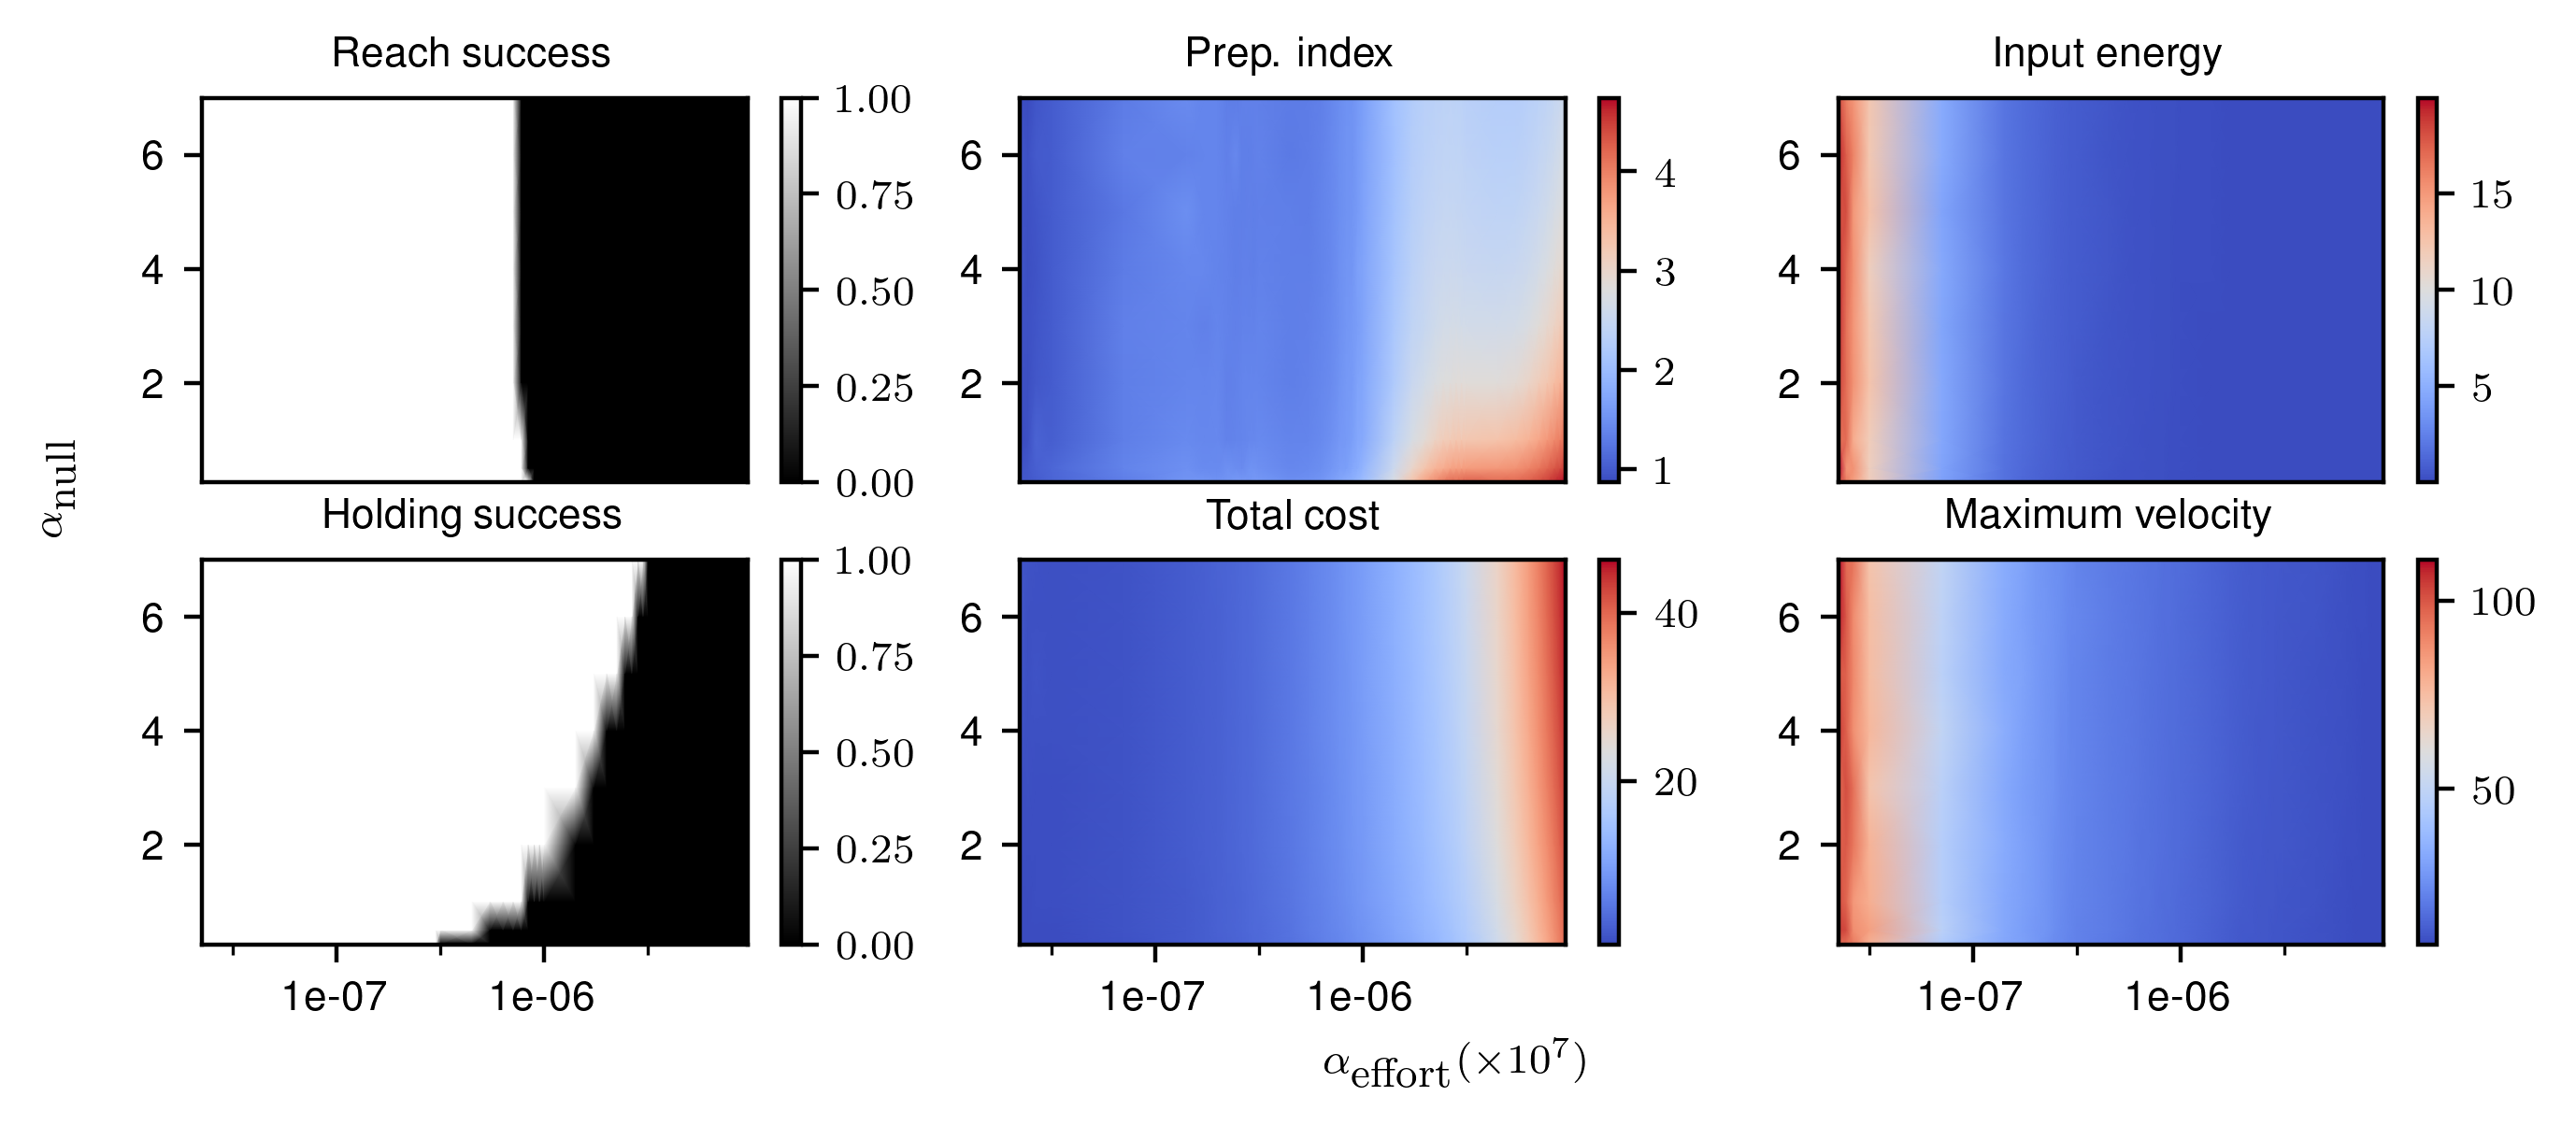

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=3,  figsize=(8, 3), dpi = 400)
import matplotlib as mpl

"""----------------------------------------------------
                    Successful reach
-------------------------------------------------------"""
X, Y = np.meshgrid(np.asarray([float(l) for l in lambdas]), np.asarray([float(l) for l in t_coeffs]))
axes[0,0].set_title("Reach success", fontsize = fs)
cm = axes[0,0].pcolormesh(X, Y, srs, cmap="gray", shading='gouraud')
axes[0,0].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[0,0].yaxis.get_ticklocs()])
axes[0,0].get_xaxis().set_visible(False)
axes[0,0].set_xscale("logit")
fig.colorbar(cm, ax=axes[0,0])
"""----------------------------------------------------
                    Successful hold
-------------------------------------------------------"""
axes[1,0].set_title("Holding success", fontsize = fs)
axes[1,0].set_xscale("logit")
cm = axes[1,0].pcolormesh(X, Y, shs, cmap="gray", shading='gouraud')
axes[1,0].xaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,0].xaxis.get_ticklocs()])
axes[1,0].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,0].yaxis.get_ticklocs()])
fig.colorbar(cm, ax=axes[1,0])
"""----------------------------------------------------
                    Prep index
-------------------------------------------------------"""
cm = axes[0,1].pcolormesh(X, Y, pis, cmap="coolwarm", shading='gouraud')
axes[0,1].set_xscale("logit")
axes[0,1].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[0,1].yaxis.get_ticklocs()])
axes[0,1].get_xaxis().set_visible(False)
axes[0,1].set_title("Prep. index", fontsize = fs)
fig.colorbar(cm, ax=axes[0,1])
# axes[0,1].xaxis.set_ticklabels([f'{t:.3g}' for t in  axes[0,1].xaxis.get_ticklocs()])

"""----------------------------------------------------
                    Loss
-------------------------------------------------------"""
cm = axes[1,1].pcolormesh(X, Y, losses*2E-3, cmap="coolwarm", shading='gouraud')
axes[1,1].set_xscale("logit")
axes[1,1].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,1].yaxis.get_ticklocs()])
axes[1,1].xaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,1].xaxis.get_ticklocs()])
axes[1,1].set_title("Total cost", fontsize = fs)
fig.colorbar(cm, ax=axes[1,1])
"""----------------------------------------------------
                    Input energy
-------------------------------------------------------"""
cm = axes[0,2].pcolormesh(X, Y, tot_us*2E-3, cmap="coolwarm", shading='gouraud')
axes[0,2].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[0,2].yaxis.get_ticklocs()])
axes[0,2].set_xscale("logit")
axes[0,2].get_xaxis().set_visible(False)
axes[0,2].set_title("Input energy", fontsize = fs)
#axes[0,2].set_xticks(range(len(lambdas)),  [])
#axes[0,2].set_yticks(range(len(t_coeffs)),  [])
fig.colorbar(cm, ax=axes[0,2])
"""----------------------------------------------------
                    Maximum velocity
-------------------------------------------------------"""
cm = axes[1,2].pcolormesh(X, Y, max_vels, cmap="coolwarm", shading='gouraud')
axes[1,2].yaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,2].yaxis.get_ticklocs()])
axes[1,2].set_xscale("logit")
axes[1,2].xaxis.set_ticklabels([f'{t:.3g}' for t in  axes[1,2].xaxis.get_ticklocs()])
axes[1,2].set_title("Maximum velocity", fontsize = fs)
fig.colorbar(cm, ax=axes[1,2])



#labels
fig.text(0.5, 0.01, '$\\alpha_{\\textrm{effort}} (\\times 10^{7})$', size = 8)
fig.text(0.07, 0.5, '$\\alpha_{\\textrm{null}}$', size = 8, rotation="vertical")
fig.savefig("hyperparams_2.pdf", format = "pdf", bbox_inches='tight')

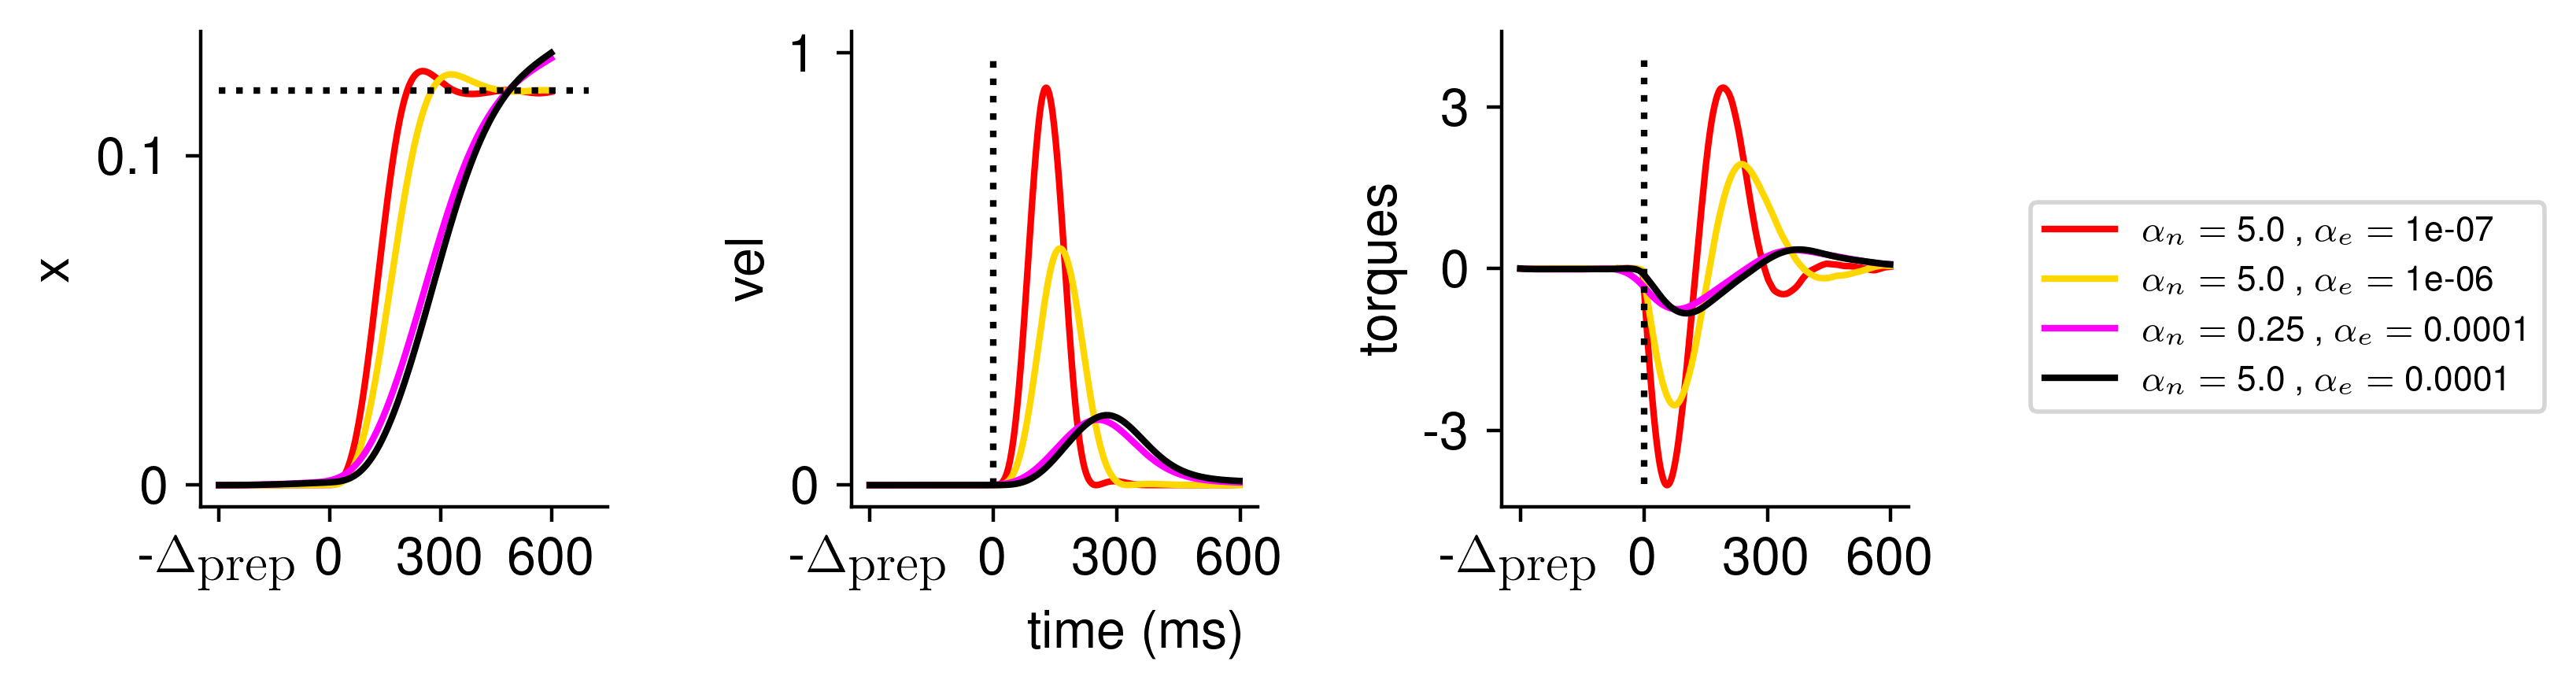

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3,  figsize=(7, 2), dpi = 400)
plt.subplots_adjust(wspace = 0.6)

fs = 12
import matplotlib as mpl
def hand(lam, tcoeff):
    try : 
        try : 
            return np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/hands_{lam:.8f}_{tcoeff:.3f}_0_150")
        except : 
            return np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/hands_{lam:.8f}_{tcoeff:.3f}_1_150")
    except : 
        return np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/hands_{lam:.8f}_{tcoeff:.3f}_2_150")

def torques(lam, tcoeff):
    try : 
        try : 
            return np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/torques_{lam:.8f}_{tcoeff:.3f}_0_150")
        except : 
            return np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/torques_{lam:.8f}_{tcoeff:.3f}_1_150")
    except : 
        return np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan2/torques_{lam:.8f}_{tcoeff:.3f}_2_150")
colors = ["dodgerblue", "red", "green", "gold", "magenta", "black"]
"""----------------------------------------------------
                    Pos x
-------------------------------------------------------"""
for i, lam in enumerate([1E-7, 1E-6, 1E-4]):
    for j, t in enumerate([0.25, 5.0]):
        if not (2*i + j == 0 or 2*i + j == 2):
            axes[0].plot(hand(lam,t)[:,0], color = colors[2*i+j], label = f"$\\alpha_n = $ {t} , $\\alpha_e = $ {lam}")
    axes[0].legend(loc = (4.5, 0.2))
axes[0].set_ylabel("x", fontsize = fs)
"""----------------------------------------------------
                    Velocity
-------------------------------------------------------"""
for i, lam in enumerate([1E-7, 1E-6, 1E-4]):
    for j, t in enumerate([0.25, 5.0]):
        if not (2*i + j == 0 or 2*i + j == 2):
            axes[1].plot(hand(lam,t)[:,1]**2 + hand(lam,t)[:,3]**2, color = colors[2*i+j])

for i, lam in enumerate([1E-7, 1E-6, 1E-4]):
    for j, t in enumerate([0.25, 5.0]):
        if not (2*i + j == 0 or 2*i + j == 2):
            axes[2].plot(torques(lam, t)[:,0], color = colors[2*i+j])
axes[2].set_ylabel("torques", fontsize = fs)
axes[0].set_xticks([0,150,300, 450], ['-$\\Delta_\\textrm{prep}$', '0', '300', '600'], fontsize=fs)
axes[0].hlines(0.12, 0, 500, color = 'k', linestyle = "dotted")
axes[0].set_yticks([0,0.1],[0,0.1], fontsize=fs)
axes[1].set_yticks([0,1],[0,1], fontsize=fs)
axes[2].set_yticks([-3,0,3],[-3,0,3], fontsize=fs)
axes[1].set_xticks([0,150,300, 450], ['-$\\Delta_\\textrm{prep}$', '0', '300', '600'], fontsize=fs)
axes[2].set_xticks([0,150,300, 450], ['-$\\Delta_\\textrm{prep}$', '0', '300', '600'], fontsize=fs)
axes[1].vlines(150, 0, 1, color = 'k', linestyle = "dotted")
axes[2].vlines(150, -4, 4, color = 'k', linestyle = "dotted")
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[1].set_ylabel("vel", fontsize = fs)
fig.text(0.5, -0.1, 'time (ms)', fontsize = fs)
fig.savefig("hyperparams_beh.pdf", format = "pdf", bbox_inches='tight')


In [ ]:
lam = 0.00000005
t_coeff = 1.000
hands = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan/hands_0.00000005_5.000_1_150")
hands = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams/monkeys_0.05_0.0000001_9.0/ramping_soc/seed_1_mixed/hands_0_400")
hand_targets = np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams/monkeys_0.01_0.000001_1.0/ramping_soc/seed_0_mixed/hand_targets")
plt.plot(hands[:,1]**2 + hands[:,3]**2)
plt.figure()
plt.plot(hands[:,0] - hands[0,0], hands[:,2] - hands[0,2])
plt.plot(hand_targets[:,0], hand_targets[:,1], "ko")
plt.figure()
plt.plot(np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams/monkeys_0.05_0.0000001_9.0/ramping_soc/seed_1_mixed/rates_0_400")[:,:200])

FileNotFoundError: /home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/hyperparams_scan/hands_0.00000005_5.000_1_150 not found.